# Описание Задачи.
Необходимо проверить гипотезу что новый алгоритм рекомендаций во 2-й группе привел к увеличению CTR. Проведем несколько тестов:
* графический анализ
* сравним Т-тестом CTR группы А и группы В
* сравним Т-тестом сглаженный CTR группы А и группы В
* сравним группы А и В с помощью Бутстрэп
* Сделаем тест Мана-уитни поверх бакетов


Дадим итоговую рекомендацию новый алгоритм.

In [26]:
import pandahouse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import hashlib # Делать хеши
import swifter # Ускорялка метода apply
from scipy import stats # Статистика
from scipy.stats import norm, ttest_ind
%matplotlib inline

from scipy.stats import mannwhitneyu

In [27]:
# создаёт словарь с именем connection, который содержит информацию для подключения к базе данных ClickHouse.
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}

In [28]:
# скачиваем данные из clickhouse группы 2 и 1. С '2021-11-15' по '2021-11-21'
q = """
SELECT exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions
WHERE toDate(time) between '2021-11-14' and '2021-11-20' and exp_group in (2,1)
GROUP BY exp_group, user_id
"""
df = pandahouse.read_clickhouse(q, connection=connection)


In [29]:
# посмотрим как выглядят наши данные
df.head(3)

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575


In [30]:
# посмотрим размер обоих групп
df.groupby('exp_group',as_index =False).agg({'user_id':'count'}) 

,exp_group,user_id
0,1,9990
1,2,9816


In [31]:
# разделим по группам
group_A = df[df.exp_group == 2].copy()
group_B = df[df.exp_group == 1].copy()

# Т-тест
сравним Т-тестом CTR группы А и группы В

In [32]:
# сравним Т-тестом CTR группы А и группы В
stats.ttest_ind(group_A.ctr, group_B.ctr, equal_var = False)

TtestResult(statistic=-0.23188350876573682, pvalue=0.816631524919649, df=15652.331576916213)

Т-тест утверждает что отличий нет(потому что pvalue большое, сильно больше чем 0,5). То есть у нас недостаточно оснований сказать, что отличия есть. 

# сглаженный CTR
Сравним Т-тестом сглаженный CTR группы А и группы В

In [33]:
# функция для сглаженного CTR
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

# считаем общегрупповой CTR для группы А и В
global_ctr_A = df[df.exp_group == 2].likes.sum() / df[df.exp_group == 2].views.sum()
global_ctr_B = df[df.exp_group == 1].likes.sum() / df[df.exp_group == 1].views.sum()

In [34]:
# построим метрику сглаженного CTR для группы А и В
# (просто применим функцию, гиперпараметр присвоили 5)
group_A['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_A, 5), axis=1)

group_B['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_B, 5), axis=1)


In [35]:
display(group_A.head(2))
display(group_B.head(2))

,exp_group,user_id,likes,views,ctr,smothed_ctr
5,2,131473,14,175,0.080000,0.083297
6,2,23985,13,119,0.109244,0.112851


,exp_group,user_id,likes,views,ctr,smothed_ctr
0,1,109963,3,15,0.20000,0.202140
1,1,26117,32,141,0.22695,0.226321


In [36]:
# сравним Т-тестом сглаженные CTR группы А и группы В
stats.ttest_ind(group_A.smothed_ctr, group_B.smothed_ctr, equal_var = False)

TtestResult(statistic=-1.8450532173987262, pvalue=0.06504892715455249, df=15446.871882444922)

Получили pvalue=0.06  чуть больше 0,05 это означает что не отвергаем нулевую гипотезу, но ситуация совсем не одназназная. 

# Гистограма распределений
**Посмотрим как выглядят наши расспределения CTR**

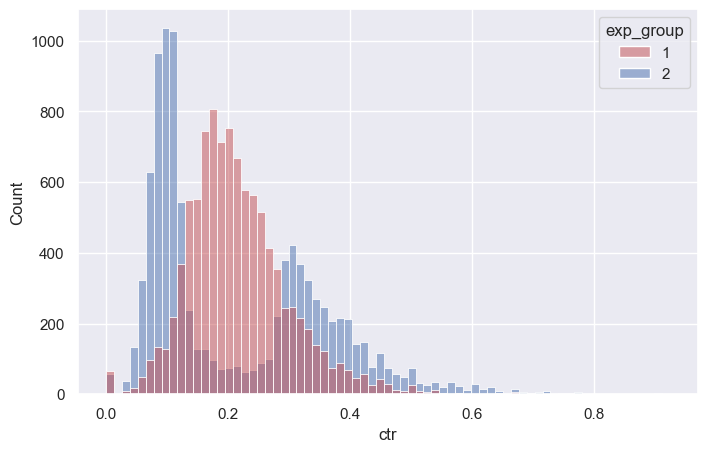

In [37]:
sns.set(rc={'figure.figsize':(8, 5)})
groups = sns.histplot(data=df,
                      x='ctr',
                      hue='exp_group',
                      palette = ['r', 'b'],
                      alpha=0.5,
                      kde=False)

Распределения полностью поменяли форму! В контрольной группе распределение осталось одногорбое похожее на нормальное, а в эксперементальной группе горба стало 2! 


Почему наш стандартный Т-тест не заметил различия? Потому, что средние значения почти не отличаются

In [38]:
# выведем средний CTR в группе А и В
global_ctr_A, global_ctr_B

(0.19870276252473978, 0.20856005935536234)

# Бутстрэп. 

Сравним группы А и В с помощью Бутстрэп

In [39]:
#на вход функция принимает лайки и просмотры по группам, а также указываем что бутстреп будет проводиться 2000 раз
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):
    # 2000 раз генерируем веса из расспределения пуассона для группы А и для группы В
    poisson_bootstraps1 = stats.poisson(1).rvs((n_bootstrap, len(likes1))).astype(np.int64)
    poisson_bootstraps2 = stats.poisson(1).rvs((n_bootstrap, len(likes2))).astype(np.int64)

    # считаем глобальный CTR для группы А и В(поскольку мы это делаем 2000 раз мы получаем расспределение 
    # из 2000 глобальных CTR для группы А и 2000 глобальных CTR для группы В)
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)
    
    return globalCTR1, globalCTR2

In [40]:
# достанем из clickhouse данные по пользователям группы 1 и группы 2
q = """
SELECT exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions
WHERE toDate(time) between '2021-11-15' and '2021-11-21' and exp_group in (1,2)
GROUP BY exp_group, user_id
"""
df = pandahouse.read_clickhouse(q, connection=connection)

In [41]:
df.head(2)

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.20000
1,1,26117,32,141,0.22695


In [42]:
# отделим лайки и просмотры для контрольной группы и тестовой
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

In [43]:
# применим функцию и получим распределение глобальных CTR 
ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

<Axes: ylabel='Count'>

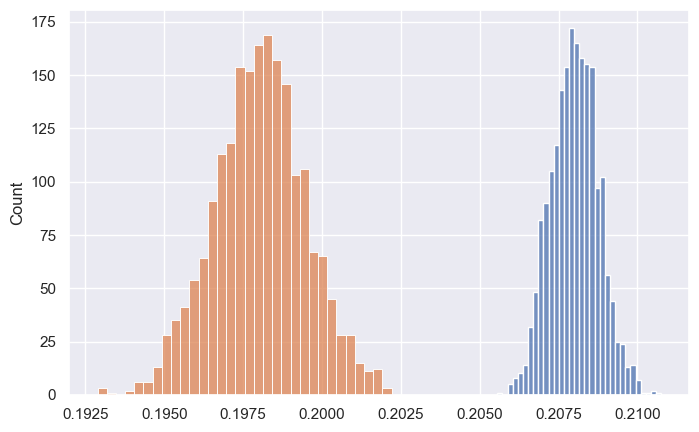

In [44]:
sns.histplot(ctr1)
sns.histplot(ctr2)

Как видно бутстрэп нам утверждает, что наш новый алгоритм(слева) значимо хуже(полностью разнесены распределения) чем наш старый алгоритм.

# Бакеты

Сделаем тест Мана-уитни поверх бакетов

In [45]:

q = """
SELECT exp_group, 
    xxHash64(user_id)%50 as bucket,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as bucket_ctr
 FROM {db}.feed_actions
    WHERE toDate(time) between '2021-11-15' and '2021-11-21' and exp_group in (1,2)
GROUP BY exp_group, bucket
"""
df = pandahouse.read_clickhouse(q, connection=connection)


In [46]:
df.head(2)

,exp_group,bucket,likes,views,bucket_ctr
0,1,0,2624,13355,0.196481
1,2,0,2634,13559,0.194262


In [47]:
# тест Манна-Уитни
stats.mannwhitneyu(df[df.exp_group == 1].bucket_ctr,
                df[df.exp_group == 2].bucket_ctr,
                alternative = 'two-sided')

MannwhitneyuResult(statistic=1995.0, pvalue=2.859963936492646e-07)

Тест мана-уитни тоже видит значимое отличие. pvalue сильно меньше 0,05 

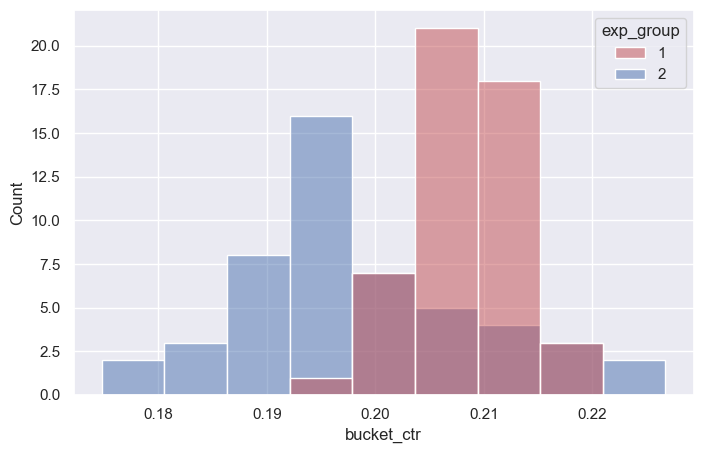

In [48]:
# нарисуем бакетное распределение
sns.set(rc={'figure.figsize':(8, 5)})
groups = sns.histplot(data=df,
                      x='bucket_ctr',
                      hue='exp_group',
                      palette = ['r', 'b'],
                      alpha=0.5,
                      kde=False)

Видим что бакетное распределение тоже явно отличаеться. 

**Финальное решение**


С точки зрения общегруппового CTR наш новый алгорит хуже. Это доказываеться бутстрэпом, тестом мана-уитни поверх бакетов. Это даже можно пронаблюдать глазами. 


Но в новом алгоритме есть несколько интересных моментов. Появились пользователи у которых CTR существено повысился. Если мы получаем большую часть денег именно с этих пользователей, то наша целевая метрика которую нужно сравнивать это не среднее значение CTR а какой нибудь соответствующий квантиль распределения CTR. 



Совершено точно этот тест полезен, но на всех пользователей его не стоит раскатывать. 